# Read evaluation and generate tables and bar plots
Goal: reproduce result summaries from the platform to integrate them in the paper.

In [42]:
from icdar24_maptext_analysis.loaders import check_for_missing_images, VALID_SUBSETS, VALID_TASKS, load_results, list_results 
from icdar24_maptext_analysis.paths import RELPATH_FILE_SUBMISSIONS_META
import pandas as pd

Quickly check we have all images from test sets available.

Note: generation of figures with images may be extracted to another notebook for clarity and to avoid the need to download image test sets for basic graph generation.

In [4]:
for subset in ("ign", ):  #VALID_SUBSETS:
    if len(missing_image := check_for_missing_images(subset)) > 0:
        print(f"Missing images in {subset}: {missing_image}")
        raise RuntimeError(f"Missing images in {subset}")

## Read metadata and filter content

Load the metadata file and set the submission id as index.

In [5]:
submissions_meta = pd.read_csv(RELPATH_FILE_SUBMISSIONS_META).set_index('ID')
submissions_meta

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114581,94279,user_51343,2024-05-06 04:57:11,28,2,1,1,0,MapText Detection-Linking Strong Pipeline,165918784,1,00:22:04,792.0
114582,94280,user_51343,2024-05-06 05:00:51,28,3,1,1,0,MapText Detection and Recognition Strong Pipeline,154636953,1,00:22:05,910.0
114583,94281,user_51343,2024-05-06 05:16:27,28,4,1,1,0,MapText Detection-Recognition-Linking Strong P...,165918784,1,00:22:04,939.0


Check for outliers in the various validity indicators.

In [7]:
submissions_meta[["Valid", "Competition", "Val. Set", "Public"]].value_counts()

Valid  Competition  Val. Set  Public
1      1            0         1         63
Name: count, dtype: int64

Ok, all submissions we got are valid submissions for the report, except for duplicates to filter and some test from sergi.
We will keep only the last submission for each user and check this is consistent with manual flagging.

In [22]:
# Set the Date column to datetime
submissions_meta["Date"] = pd.to_datetime(submissions_meta["Date"])
submissions_meta.head(5)

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0


In [28]:
lastest_submissions = submissions_meta.groupby(["User", "Task"])['Date'].idxmax()
lastest_submissions

User        Task
sergi       1       114304
user_32125  1       113826
user_36250  1       113464
            2       113462
            3       113461
            4       113460
user_43613  1       114279
            2       114549
            3       114283
            4       114551
user_50898  1       114288
            3       114293
user_51343  1       114579
            2       114581
            3       114582
            4       114583
user_51436  1       114302
user_51723  1       113751
user_52424  1       113413
user_53137  1       114534
            3       114536
user_53700  1       114303
user_9      1       113478
            2       113480
            3       113479
            4       113481
Name: Date, dtype: int64

Based on a manual check, it looks like the following submissions can be deleted from our analysis as duplicates:

- Task 1: 114256, 114281, 114292
- Task 2: 114294, 114580
- Task 3: 114289, 114291, 114322
- Task 4: 114295, 114583, 114584

We believe all of them have Rumsey entries, but not all of them may have IGN entries.

In [29]:
duplicate_submission_ids_manual = [
    114256, 114281, 114292,  # task 1
    114294, 114580,  # task 2
    114289, 114291, 114322,  # task 3
    114295, 114583, 114584]  # task 4

We want the manual set of duplicates to be the complement of the set of latest submissions in the set of all submissions.
Let us check this.

In [30]:
len(submissions_meta.index), len(duplicate_submission_ids_manual), len(lastest_submissions)

(63, 11, 26)

In [31]:
set(duplicate_submission_ids_manual) | set(lastest_submissions) == set(submissions_meta.index)

False

In [32]:
len(set(submissions_meta.index) - set(lastest_submissions))

37

In [33]:
len(set(submissions_meta.index) - set(duplicate_submission_ids_manual))

52

In [34]:
set(duplicate_submission_ids_manual) & set(lastest_submissions)

{114583}

In [45]:
available_results = []
for task_id in VALID_TASKS:
    for subset in VALID_SUBSETS:
        available_results.extend(list_results(task_id, subset))
available_results = set(int(x) for x in available_results)
len(available_results)

35

In [75]:
len(available_results & set(lastest_submissions))

22

In [77]:
len(available_results - set(duplicate_submission_ids_manual))

24

In [71]:
# Show filtered submissions which do not have an evaluation
submissions_meta_noeval = submissions_meta.loc[~submissions_meta.index.isin(available_results)]
print(f"Total submissions: {len(submissions_meta)}, avail. eval: {len(available_results)}, discarded: {len(submissions_meta_noeval)}")
submissions_meta_noeval

Total submissions: 63, avail. eval: 35, discarded: 28


,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113463,93161,user_36250,2024-03-26 06:28:50,28,1,1,1,0,DS-LP,14289896,1,00:01:09,792.0
113751,93449,user_51723,2024-04-12 13:57:38,28,1,1,1,0,Test title,13838542,1,00:00:37,642.0
113761,93459,user_51436,2024-04-13 07:26:49,28,1,1,1,0,DiT,82748940,1,00:01:27,778.0
113777,93475,user_51436,2024-04-14 20:18:40,28,1,1,1,0,MViT,74655170,1,00:01:22,791.0
113786,93484,user_50898,2024-04-15 10:04:39,28,3,1,1,0,submit_test_v1,2,1,00:00:21,364.0
113826,93524,user_32125,2024-04-17 10:24:37,28,1,1,1,0,MapTest,1415605,1,00:00:16,395.0
113853,93551,user_50898,2024-04-18 10:37:15,28,3,1,1,0,submit_test_v1,207656779,1,00:01:26,454.0


In [51]:
submissions_meta_valid = submissions_meta.loc[list(available_results - set(duplicate_submission_ids_manual))]
submissions_meta_valid

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
114579,94277,user_51343,2024-05-06 04:49:46,28,1,1,1,0,MapText Detection Strong Pipeline,165918784,1,00:06:44,792.0
114197,93895,user_51436,2024-04-27 16:10:36,28,1,1,1,0,ensem,96110879,1,00:22:08,791.0
114581,94279,user_51343,2024-05-06 04:57:11,28,2,1,1,0,MapText Detection-Linking Strong Pipeline,165918784,1,00:22:04,792.0
114582,94280,user_51343,2024-05-06 05:00:51,28,3,1,1,0,MapText Detection and Recognition Strong Pipeline,154636953,1,00:22:05,910.0
114585,94283,user_51343,2024-05-06 05:16:27,28,4,1,1,0,MapText Detection-Recognition-Linking Strong P...,165918784,1,-08:43:29,942.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
113464,93162,user_36250,2024-03-26 06:33:14,28,1,1,1,0,DS-LP,14289896,1,00:05:55,792.0


In [54]:
# count the number of submissions per user for each task
submissions_meta_valid.groupby(["User", "Task"]).size().unstack().fillna(0)

Task,1,2,3,4
User,,,,
user_36250,1.0,1.0,1.0,1.0
user_43613,1.0,1.0,1.0,1.0
user_50898,1.0,0.0,1.0,0.0
user_51343,1.0,1.0,1.0,1.0
user_51436,3.0,0.0,0.0,0.0
user_53137,1.0,0.0,1.0,0.0
user_53700,1.0,0.0,0.0,0.0
user_9,1.0,1.0,1.0,1.0


Total submissions: 63, avail. eval: 35, discarded: 28


,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113463,93161,user_36250,2024-03-26 06:28:50,28,1,1,1,0,DS-LP,14289896,1,00:01:09,792.0
113751,93449,user_51723,2024-04-12 13:57:38,28,1,1,1,0,Test title,13838542,1,00:00:37,642.0
113761,93459,user_51436,2024-04-13 07:26:49,28,1,1,1,0,DiT,82748940,1,00:01:27,778.0
113777,93475,user_51436,2024-04-14 20:18:40,28,1,1,1,0,MViT,74655170,1,00:01:22,791.0
113786,93484,user_50898,2024-04-15 10:04:39,28,3,1,1,0,submit_test_v1,2,1,00:00:21,364.0
113826,93524,user_32125,2024-04-17 10:24:37,28,1,1,1,0,MapTest,1415605,1,00:00:16,395.0
113853,93551,user_50898,2024-04-18 10:37:15,28,3,1,1,0,submit_test_v1,207656779,1,00:01:26,454.0


In [34]:
# Filter the submissions meta to only keep the latest submissions
submissions_meta = submissions_meta.loc[lastest_submissions]
submissions_meta

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
114304,94002,sergi,2024-04-29 18:01:01,28,1,1,1,0,Test,14289896,1,00:06:06,793.0
113826,93524,user_32125,2024-04-17 10:24:37,28,1,1,1,0,MapTest,1415605,1,00:00:16,395.0
113464,93162,user_36250,2024-03-26 06:33:14,28,1,1,1,0,DS-LP,14289896,1,00:05:55,792.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
114279,93977,user_43613,2024-04-29 16:14:16,28,1,1,1,0,MapTest,24947424,1,00:17:15,790.0
114549,94247,user_43613,2024-05-05 07:12:56,28,2,1,1,0,MapTest,24160040,1,00:15:13,791.0
114283,93981,user_43613,2024-04-29 16:18:04,28,3,1,1,0,MapTest,24947424,1,00:16:05,908.0


In [83]:
# Filter submissions from sergi as they are not part of the competition
# Keep Jerod's (user_9) submissions as they are the baseline
submissions_meta = submissions_meta[~submissions_meta['User'].isin(['sergi',])]
submissions_meta

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113826,93524,user_32125,2024-04-17 10:24:37,28,1,1,1,0,MapTest,1415605,1,00:00:16,395.0
113464,93162,user_36250,2024-03-26 06:33:14,28,1,1,1,0,DS-LP,14289896,1,00:05:55,792.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
114279,93977,user_43613,2024-04-29 16:14:16,28,1,1,1,0,MapTest,24947424,1,00:17:15,790.0
114549,94247,user_43613,2024-05-05 07:12:56,28,2,1,1,0,MapTest,24160040,1,00:15:13,791.0
114283,93981,user_43613,2024-04-29 16:18:04,28,3,1,1,0,MapTest,24947424,1,00:16:05,908.0
114551,94249,user_43613,2024-05-05 07:17:28,28,4,1,1,0,MapTest,24160040,1,00:30:19,935.0


In [37]:
# Display some statistics about the nomber of submissions per user
submissions_meta['User'].value_counts()

User
user_36250    4
user_43613    4
user_51343    4
user_50898    2
user_53137    2
user_32125    1
user_51436    1
user_51723    1
user_52424    1
user_53700    1
Name: count, dtype: int64

In [38]:
#  Display some statistics about the nomber of submissions for each task (though this does not say which dataset(s) the sumbission was made on)
submissions_meta['Task'].value_counts()

Task
1    10
3     5
2     3
4     3
Name: count, dtype: int64

In [40]:
submissions_meta[submissions_meta['Task'] == 4]

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
114551,94249,user_43613,2024-05-05 07:17:28,28,4,1,1,0,MapTest,24160040,1,00:30:19,935.0
114583,94281,user_51343,2024-05-06 05:16:27,28,4,1,1,0,MapText Detection-Recognition-Linking Strong P...,165918784,1,00:22:04,939.0


In [81]:
# FIXME is this correct? don't we filter out submissions which submitted only one file for a given task?
# for instance, there are 7 files for task4, file 1 but only 6 for task4, file 2
# only in file 1:
# data/00-input/defaults-20240507074007/data/ch28/t4/f1/114295.json
# no, this seems OK, it was an extra submission from the same user


# -> We could either have 8 tables, or we could have 4 tables with a “left” part for Rumsey and a “right” part for IGN, (blank  when an entry skipped one of the evaluations)

In [44]:
# Gather list of final submissions ids from the filtered submissions meta
final_submission_ids = list(submissions_meta.index)
len(final_submission_ids)

21

In [51]:
list_results(1, "ign")[:3]

['113464', '113478', '114197']

In [52]:
final_submission_ids[:3]

[113826, 113464, 113462]

In [50]:
set(list_results(1, "ign")) & set(final_submission_ids)

set()

In [55]:
results_ign_t1_global, results_ign_t1_images = load_results(1, 'ign', filter=lambda s: int(s) in final_submission_ids)

In [56]:
results_ign_t1_global

quality    fscore  tightness  precision  \
task_id subset submission_id                                             
1       ign    113464         0.440816  0.677835   0.650329   0.648477   
               114279         0.642150  0.919120   0.698657   0.908254   
               114302         0.647473  0.897328   0.721557   0.886843   
               114303         0.357344  0.547015   0.653262   0.701293   
               114579         0.423305  0.610959   0.692854   0.825111   

                                recall  
task_id subset submission_id            
1       ign    113464         0.709977  
               114279         0.930249  
               114302         0.908063  
               114303         0.448376  
               114579         0.485064

In [7]:
results_ign_t1_images

quality    fscore  \
task_id subset submission_id image_id                                  
1       ign    113464        ign/test/000001.jpg  0.334972  0.551724   
                             ign/test/000002.jpg  0.417264  0.629630   
                             ign/test/000003.jpg  0.535378  0.821429   
                             ign/test/000004.jpg  0.497155  0.769231   
                             ign/test/000005.jpg  0.272915  0.436170   
...                                                    ...       ...   
               114579        ign/test/000046.jpg  0.578814  0.827068   
                             ign/test/000047.jpg  0.277220  0.416667   
                             ign/test/000048.jpg  0.614602  0.854839   
                             ign/test/000049.jpg  0.675593  0.913907   
                             ign/test/000050.jpg  0.238192  0.364425   

                                                  tightness  precision  \
task_id subset submission_id image_id                                    
1       ign    113464        ign/test/000001.jpg   0.607137   0.538462   
                             ign/test/000002.jpg   0.662714   0.586207   
                             ign/test/000003.jpg   0.651765   0.821429   
                             ign/test/000004.jpg   0.646302   0.747331   
                             ign/test/000005.jpg   0.625707   0.303704   
...                                                     ...        ...   
               114579        ign/test/000046.jpg   0.699838   0.948276   
                             ign/test/000047.jpg   0.665327   0.489130   
                             ign/test/000048.jpg   0.718968   0.873626   
                             ign/test/000049.jpg   0.739236   0.981043   
                             ign/test/000050.jpg   0.653611   0.705882   

                                                    recall  
task_id subset submission_id image_id                       
1       ign    113464        ign/test/000001.jpg  0.565657  
                             ign/test/000002.jpg  0.680000  
                             ign/test/000003.jpg  0.821429  
                             ign/test/000004.jpg  0.792453  
                             ign/test/000005.jpg  0.773585  
...                                                    ...  
               114579        ign/test/000046.jpg  0.733333  
                             ign/test/000047.jpg  0.362903  
                             ign/test/000048.jpg  0.836842  
                             ign/test/000049.jpg  0.855372  
                             ign/test/000050.jpg  0.245614  

[400 rows x 5 columns]

In [57]:
results_ign_t1_global["Title"] = results_ign_t1_global.index.map(lambda idx: submissions_meta.loc[int(idx[2]), "Title"])
results_ign_t1_global

quality    fscore  tightness  precision  \
task_id subset submission_id                                             
1       ign    113464         0.440816  0.677835   0.650329   0.648477   
               114279         0.642150  0.919120   0.698657   0.908254   
               114302         0.647473  0.897328   0.721557   0.886843   
               114303         0.357344  0.547015   0.653262   0.701293   
               114579         0.423305  0.610959   0.692854   0.825111   

                                recall                                Title  
task_id subset submission_id                                                 
1       ign    113464         0.709977                                DS-LP  
               114279         0.930249                              MapTest  
               114302         0.908063                             dino_map  
               114303         0.448376                               MapDet  
               114579         0.485064  MapText Detection Strong Pipeline

In [71]:
results_ign_t1_global[["Title", "quality"]].sort_values("quality", ascending=False)

Title   quality
task_id subset submission_id                                               
1       ign    114302                                    dino_map  0.647473
               114279                                     MapTest  0.642150
               113464                                       DS-LP  0.440816
               114579         MapText Detection Strong Pipeline    0.423305
               114303                                      MapDet  0.357344

In [82]:
# FIXME report numbers as 0-100 (percentages) either by multiplying by 100 or by changing the formatter

# Note: do not change submission names, to ensure consistency with the online platform
# TODO however, shorten long submission names with ellipses, like for instance “MapText…Strong Pipeline”. Make sure this is consistent across the various tasks.

# print(results_ign_t1_global[["Title", "quality"]].sort_values("quality", ascending=False).reset_index(drop=True).to_latex())
print(results_ign_t1_global[["Title", "quality"]].sort_values("quality", ascending=False).to_latex(index=False))

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
dino_map & 0.647473 \\
MapTest & 0.642150 \\
DS-LP & 0.440816 \\
MapText Detection Strong Pipeline   & 0.423305 \\
MapDet & 0.357344 \\
\bottomrule
\end{tabular}



<Axes: title={'center': 'Quality score for task 1 on IGN subset'}, xlabel='Quality score'>

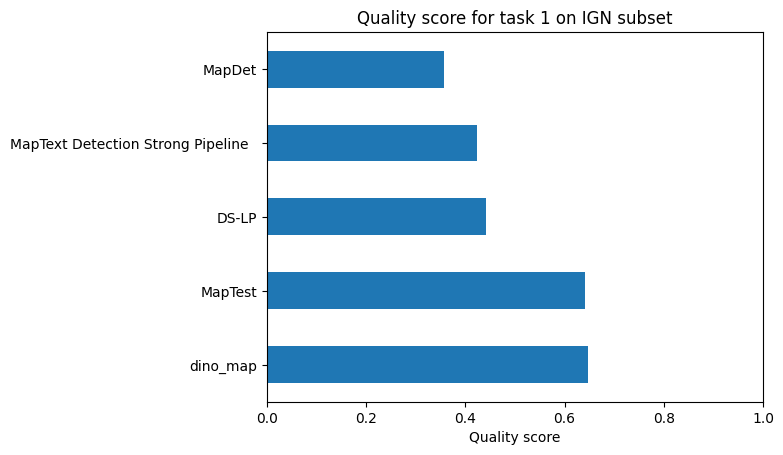

In [80]:
results_ign_t1_global[["Title", "quality"]].sort_values("quality", ascending=False).plot.barh(x="Title", y="quality", title="Quality score for task 1 on IGN subset", ylabel="", xlabel="Quality score", legend=False, xlim=(0, 1))